# Hands on Embeddings - implementing word2vec using Gensim 

Word2vec is a popular technique to learn word embeddings. It uses a two-layer neural network. Its input is a text corpus and its output is a set of vectors. Word embedding via word2vec can make natural language computer-readable, then further implementation of mathematical operations on words can be used to detect their similarities. A well-trained set of word vectors will place similar words close to each other in that space. For instance, the words women, men and human might cluster in one corner, while yellow, red and blue cluster together in another.

Word2Vec was introduced in two papers between September and October 2013, by a team of researchers at Google. Along with the papers, the researchers published their implementation in C. The Python implementation was done soon after the 1st paper, by Gensim.

The underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model. For instance: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representation.

From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

There are two main training algorithms for word2vec, one is the continuous bag of words(CBOW), another is called skip-gram. The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generally, the skip-gram method can have a better performance compared with CBOW method, for it can capture two semantics for a single word. For instance, it will have two vector representations for Apple, one for the company and another for the fruit.

The secret to getting Word2Vec really working for you is to have lots and lots of text data in the relevant domain. For example, if your goal is to build a sentiment lexicon, then using a dataset from the medical domain or even Wikipedia may not be effective. So the choice of dataset and application is important. Here we choose a failry small text, but ideally you will need much more data!

### word2vec using Gensim 

In this example we use the Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html
        
Gensim is an open-source library for unsupervised topic modeling and natural language processing, using modern statistical machine learning. Gensim is implemented in Python and Cython.

In this example we take a text document and clean it and then train a word2vec model. Specifically, each sentence must be tokenized, meaning divided into words and prepared (e.g. perhaps pre-filtered and perhaps converted to a preferred case). Learning a word embedding from text involves loading and organizing the text into sentences and providing them to the constructor of a new Word2Vec() instance. 

We will load the text into memory, but an iterator that progressively loads text would be required for very large text corpora.

We will then take the model and use it to look a similarity and try to visulise the vectors. 

### Order of tasks

As with most NLP tasks, its the preparing of the data that tasks most of the time! Training a model in Gensim is straightforward. However we will work through a number of pre-processing steps so we at least start to feel like a real example. The order we will do things is:

1. load the text
2. clean the text at at top level., e.g, split into chapters and remove any surplus introduction and end text 
3. split each chapter into sentences
4. preprocess and tokenise each sentence
5. train the word2vec model
6. use the model
7. visualise the model


### The text
The data set we will use here is the text from Alice in Wonderland. This is freely available from http://www.gutenberg.org/. Gutenberg is a library of over 60,000 free eBooks and a great source of text if you want to start exploring NLP and text mining.

### The packages

We will use use a variety of packages to demonstrate different aspects of cleaning and processing the text data:

* re for stripping away some characters using regex
* Gensim for simple processing, phrase detection and word2vec

In addition we will use
* matplotlib for plotting and visualising the embeddings
* sklearn for tSNE


In [1]:
import re
import spacy

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.summarization.textcleaner import get_sentences

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline

from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

## Lets load some data

In [2]:
with open("pg28885.txt", encoding='latin-1') as f:
    alice_raw_text = f.readlines()
    
# View the first 50 rows to access quality  
alice_raw_text[:50]    

['bplist00Ñ\x01\x02_\x10\x0fWebMainResourceÕ\x03\x04\x05\x06\x07\x08\t\n',
 '\x0b\x0c_\x10\x14WebResourceFrameName_\x10\x0fWebResourceData_\x10\x13WebResourceMIMEType_\x10\x1bWebResourceTextEncodingName^WebResourceURLPO\x12\x00\x02¥³<html><head></head><body><pre style="word-wrap: break-word; white-space: pre-wrap;">Project Gutenberg\'s Alice\'s Adventures in Wonderland, by Lewis Carroll\n',
 '\n',
 'This eBook is for the use of anyone anywhere at no cost and with\n',
 'almost no restrictions whatsoever.  You may copy it, give it away or\n',
 're-use it under the terms of the Project Gutenberg License included\n',
 'with this eBook or online at www.gutenberg.net\n',
 '\n',
 '\n',
 "Title: Alice's Adventures in Wonderland\n",
 '       Illustrated by Arthur Rackham. With a Proem by Austin Dobson\n',
 '\n',
 'Author: Lewis Carroll\n',
 '\n',
 'Illustrator: Arthur Rackham\n',
 '\n',
 'Release Date: May 19, 2009 [EBook #28885]\n',
 '\n',
 'Language: English\n',
 '\n',
 '\n',
 "*** START OF T

The data is one long file, with preamble, table of contents and post licence information. It is useful to split the text into chapters and remove anything other than the book text.

In [3]:
# Split into chapters - each chapter has is indicated by the text CHAPTER
chapters = ''.join(alice_raw_text).split('CHAPTER')

# We dont want the first preamble and table of contents
chapters.pop(0)

# Split the last chapter by 'The End' so we can remove all end liscencing info
n = len(chapters)-1
end = chapters[n].split("THE END")

chapters[n] = end[0]

# Lets view the forst 20 characters for each chapter
for m in chapters:
    print(m[:10])


 I


[Side
 II


[Sid
 III


[Si
 IV


[Sid
 V


[Side
 VI


[Sid
 VII


[Si
 VIII


[S
 IX


[Sid
 X


[Side
 XI


[Sid
 XII


[Si


## Preprocessing
We need to do some pre-processing for the text. Lets keep it simple for this example:

1. Initial cleaning of strings
2. Remove all punctuation and convert to lowercase
3. Lemmatise


Pre-processing is dependent on your data and should be refined on each application. fpor example you may want to remove any emails using:

data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

or use some of the very useful tagging in spaCy, e.g.,  isUrl or isEmail properties https://spacy.io/api/token

In [4]:
# Convert to list
data = chapters

# Remove first line in each chapter (the chapter number)
data = [re.sub(r"^.*\n", "", sent) for sent in data]

# Remove chapters titles/illustraions/sidenotes - these are of the form "[text]"
data = [re.sub("[\[].*?[\]]", " ", sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove the ***** text lines in the text
data = [re.sub("\*", "", sent) for sent in data]

# Remove the _ characters in the text
data = [re.sub("_", " ", sent) for sent in data]

# Lets look at how the text now looks
for m in data:
    print("CHAPTER text: %s" % m[:30])

CHAPTER text:  ALICE was beginning to get ve
CHAPTER text:  "CURIOUSER and curiouser!" cr
CHAPTER text:  THEY were indeed a queer-look
CHAPTER text:  IT was the White Rabbit, trot
CHAPTER text:  THE Caterpillar and Alice loo
CHAPTER text:  FOR a minute or two she stood
CHAPTER text:  THERE was a table set out und
CHAPTER text:  A LARGE rose-tree stood near 
CHAPTER text:  "YOU can't think how glad I a
CHAPTER text:  THE Mock Turtle sighed deeply
CHAPTER text:  THE King and Queen of Hearts 
CHAPTER text:  "HERE!" cried Alice, quite fo


### A list of tokenised sentences

Gensim word2vec is designed to take your text as a list of tokenised sentences. However you can pass the whole document as a tokenised list - if you have a lot of data it wont make too much difference. But each application is different and may depend on not taking words from neighbouring sentences.

For this example, lets split each chapter into sentences ready to create a list of tokensied sentences.

In [5]:
def doc_to_sentences(docs):
    for doc in docs:
        yield get_sentences(doc)

chapter_sentences = list(doc_to_sentences(data))

# lets view the first 5 sentences of chapter 1
list(chapter_sentences[0])[:5]

['ALICE was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, "and what is the use of a book," thought Alice, "without pictures or conversations?" So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid) whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.',
 'There was nothing so  very  remarkable in that; nor did Alice think it so  very  much out of the way to hear the Rabbit say to itself, "Oh dear!',
 'Oh dear!',
 'I shall be too late!" (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually  took a watch out of its waistcoat-pocket , 

We no longer want the sentences per chapter - word2vec just wants a list of sentences. So lets flatten the chapter list

In [6]:
sentences = list([item for chapter in chapter_sentences for item in chapter])
sentences[:5]

['"CURIOUSER and curiouser!" cried Alice (she was so much surprised, that for a moment she quite forgot how to speak good English); "now I\'m opening out like the largest telescope that ever was!',
 'Good-bye, feet!" (for when she looked down at her feet, they seemed to be almost out of sight, they were getting so far off).',
 '"Oh, my poor little feet, I wonder who will put on your shoes and stockings for you now, dears?',
 "I'm sure  I  sha'n't be able!",
 'I shall be a great deal too far off to trouble myself about you: you must manage the best way you can--but I must be kind to them," thought Alice, "or perhaps they won\'t walk the way I want to go!']

### Lets perform some simple preprocessing - we can use the build in pipeline in Gensim for this, although you can build your own.

There are lots of pre-processing tasks that we could perform - for example removing stopwords, standardining terms/acroymns (e.g., US, USA, the States -> USA) and identifying bigram and trigrams - but are these necessary?! 

#### Think of the pros and cons.

* Do stopwords add noise? Does removing them remove context?
* Does identifying common phrases help enrich the model? is your corpus big enough to identify them?

It all depends on what kind of experiment you are running and how you want to represent your documents. You can vector-ize your documents in different ways, depending on ther size of your corpus and context.

In [7]:
def sentence_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

tokensied_sentences = list(sentence_to_words(sentences))

# Lets view the first 20 words in the first chapter
print(tokensied_sentences[0])

['curiouser', 'and', 'curiouser', 'cried', 'alice', 'she', 'was', 'so', 'much', 'surprised', 'that', 'for', 'moment', 'she', 'quite', 'forgot', 'how', 'to', 'speak', 'good', 'english', 'now', 'opening', 'out', 'like', 'the', 'largest', 'telescope', 'that', 'ever', 'was']


## Bigrams and trigrams
There are a number of ways to identify phrases through a corpus. Here we show how to use the Phraser utility in Gensim. This lets you automatically detect phrases longer than one word. Using phrases, you can learn a word2vec model where “words” are actually multiword expressions, such as new_york_times or financial_crisis:

Firstly create a Phrases object, initialised with the text and some settings to control the sensitivity .
Then feed this to a Phraser object, which can be used to create bigrams. 

To get trigrams, just repeat the Phraser operation on the bigrams.
https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1174/reports/2761021.pdf

In [8]:
bigram_phrases = Phrases(tokensied_sentences, min_count=2, threshold=1)
bigram = Phraser(bigram_phrases)

trigram_phrases = Phrases(bigram[tokensied_sentences], min_count=1, threshold=1, delimiter=b'_')
trigram = Phraser(trigram_phrases)

Lets create some fucntions to help with our pipleine. We utilise spaCy for Lemmatisation and removal of some words, but you could also use NLTK.

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

# Gensim simple processing pipleine - lowercase and tokensises 
def simple_preprocessing(texts):
    return [[word for word in simple_preprocess(str(doc))] for doc in texts]

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    use spaCy lemmatisation - allowing through Nouns, Adjectives, Verbs and adverbs only
    
    https://spacy.io/api/annotation
    """
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ != '-PRON-'])
    return texts_out

### Preprocessing pipeline

We are now in position to create a pipeline to prepare the text, adding or ommitting steps as required.
Here we will remove stopwords, lemmatize create bigrams and trigrams.

-> Do you think the order of the processing matters?

-> Why would you add custom stopwords?

-> What is the effect of some preprocessing on the CBOW/skip gram models? 

-> Should you remove punctuation??

Remember that word2vec is not just a vector representing a word, but a vector representing a word and its surrounding words. 

In [10]:
# Simple Genism processing 

tokens_preprocessed = simple_preprocessing(tokensied_sentences)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
tokens_lemmatized = lemmatization(tokens_preprocessed, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Form Bigrams
tokens_bigrams = make_bigrams(tokens_lemmatized)

# Form Trigrams
tokens_trigrams = make_trigrams(tokens_bigrams)

data_processed = tokens_trigrams

#  lets look at the first and fifth sentences
print(data_processed[0])
print(data_processed[4])

['curiouser', 'curiouser', 'cry', 'alice', 'be_so', 'much', 'surprised', 'moment', 'quite', 'forget', 'how', 'speak', 'good', 'english', 'now', 'open', 'large', 'telescope', 'that', 'ever', 'be']
['shall_be', 'great_deal', 'too_far', 'trouble', 'must', 'manage', 'good', 'way', 'can', 'must_be', 'kind', 'think', 'alice', 'perhaps', 'win', 'walk', 'way', 'want', 'go']


### Gensim Word2vec

We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

We are using a simple list of lists of tokens, but for larger corpora it is better to use an iterable that streams the sentences directly from disk/network.

There are many parameters on this constructor; a few noteworthy arguments you may wish to configure are:

* size: (default 100) The number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word).
* window: (default 5) The maximum distance between a target word and words around the target word.
* min_count: (default 5) The minimum count of words to consider when training the model; words with an occurrence less than this count will be ignored.
* workers: (default 3) The number of threads to use while training.
* sg: (default 0 or CBOW) The training algorithm, either CBOW (0) or skip gram (1).

The defaults are often good enough when just getting started.

In [11]:
# Initialise the model - CBOW or skipgram
w2v_model = Word2Vec(min_count=1,
                     window=5,
                     size=300,
                     sg=1) 

#  – CBOW (Continuous bag-of-words): The order of the context words does not influence prediction
#  – Skip-grams: nearby context words are weighted more heavily than distant ones.

In [12]:
# Build the vocab
w2v_model.build_vocab(data_processed, progress_per=10000)

In [13]:
# Train the model
w2v_model.train(data_processed, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(314524, 387180)

In [14]:
# Normalise the Word2vec vectors, needed for soem similarity measures
w2v_model.init_sims(replace=True)

### Exploring the vocab

In [15]:
vocab = list(w2v_model.wv.vocab)
print ("Vocal length %d" % len(vocab))
print('Examples: %s' % vocab[:50])

Vocal length 2057
Examples: ['curiouser', 'cry', 'alice', 'be_so', 'much', 'surprised', 'moment', 'quite', 'forget', 'how', 'speak', 'good', 'english', 'now', 'open', 'large', 'telescope', 'that', 'ever', 'be', 'foot', 'when', 'look', 'seem', 'almost', 'sight', 'get', 'so_far', 'poor_little', 'wonder', 'who', 'will', 'put', 'shoe', 'stocking', 'dear', 'sure', 'sha', 'able', 'shall_be', 'great_deal', 'too_far', 'trouble', 'must', 'manage', 'way', 'can', 'must_be', 'kind', 'think']


### Lets look at how we can use the model 
Firstly lets look at some of the built in tools within Gensim. 

You can find out more at 
https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.html

In [16]:
w2v_model.wv.similar_by_word("queen", topn=5)

[('shout', 0.9245315790176392),
 ('heart', 0.8934446573257446),
 ('player', 0.8878779411315918),
 ('voice', 0.8806666731834412),
 ('quarrel', 0.880536675453186)]

In [17]:
w2v_model.wv.most_similar(negative=["queen"], topn=5)

[('vegetable', 0.0623624362051487),
 ('beau_ootiful_soo_oop', 0.015709171071648598),
 ('grow', -0.06410768628120422),
 ('good', -0.1511395275592804),
 ('can', -0.17156264185905457)]

Lets see if the name Alice is more likley to be mentioned with the word venture than hurry:

In [18]:
w2v_model.wv.similarity('alice', 'venture')

0.9642550414103849

In [19]:
w2v_model.wv.similarity('alice', 'hurry')

0.5945094812184587

Lets see iof we can spot the minor character in a list:

In [20]:
w2v_model.wv.doesnt_match("alice queen hatter caterpillar rat".split())

'queen'

In [21]:
def get_word_table(table, key):
    return pd.DataFrame(table, columns=[key, 'similarity'])

keys = [ 'alice','queen', 'caterpillar', 'hatter' ]
tables = []
for key in keys:
    tables.append(get_word_table(w2v_model.wv.similar_by_word(key), key))
pd.concat(tables, axis=1)

,alice,similarity,queen,similarity,caterpillar,similarity,hatter,similarity
0,venture,0.964255,shout,0.924532,march,0.937224,march_hare,0.969337
1,come_back,0.962352,heart,0.893445,person,0.935819,dormouse,0.929137
2,don_think,0.959577,player,0.887878,first_why,0.934721,tea,0.914445
3,waste,0.956444,voice,0.880667,invite,0.933749,well,0.914199
4,let,0.956187,quarrel,0.880537,whole,0.932696,butter,0.900529
5,riddle,0.953922,knave,0.853794,manner,0.932065,bread,0.891579
6,muchness,0.953914,shrill,0.847857,somebody,0.931336,treacle,0.878317
7,alice_cautiously,0.953622,stop,0.847853,lory,0.929356,live,0.876022
8,morning,0.952935,procession,0.845337,authority,0.928601,twinkling,0.856007
9,little_timidly,0.952704,jump,0.844167,everything_that,0.928349,course,0.855983


### Visualising the Embeddings
These embeddings are 300 dimensions. This is difficult to visualise. However there are techniques we can use to help.

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. https://mlexplained.com/2018/09/14/paper-dissected-visualizing-data-using-t-sne-explained/

Lets pick some words from the vocab and visualise the top 30 similar words to them. We will use the SKLearn t-SNE implementation to reduce the embedding to 2 and 3 dimensionand and plot with matplotlib.

In [22]:
keys = ['alice', 'queen', 'caterpillar']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [23]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=5, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


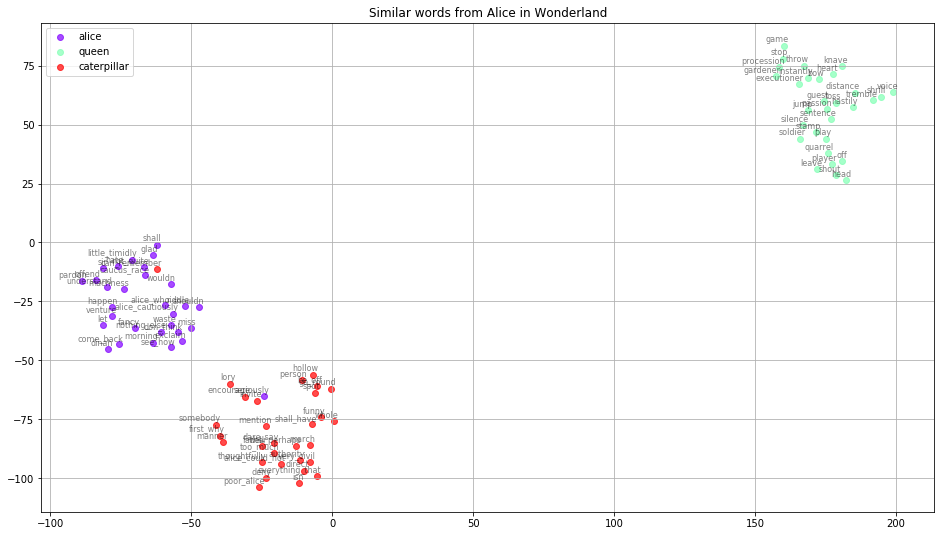

In [24]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
            
    plt.legend(loc=2)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Alice in Wonderland', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

### Viewing the embedding in 3D

In [25]:
words_sw = []
embeddings_sw = []
for word in list(w2v_model.wv.vocab):
    embeddings_sw.append(w2v_model.wv[word])
    words_sw.append(word)

In [26]:
tsne_wp_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(embeddings_sw)

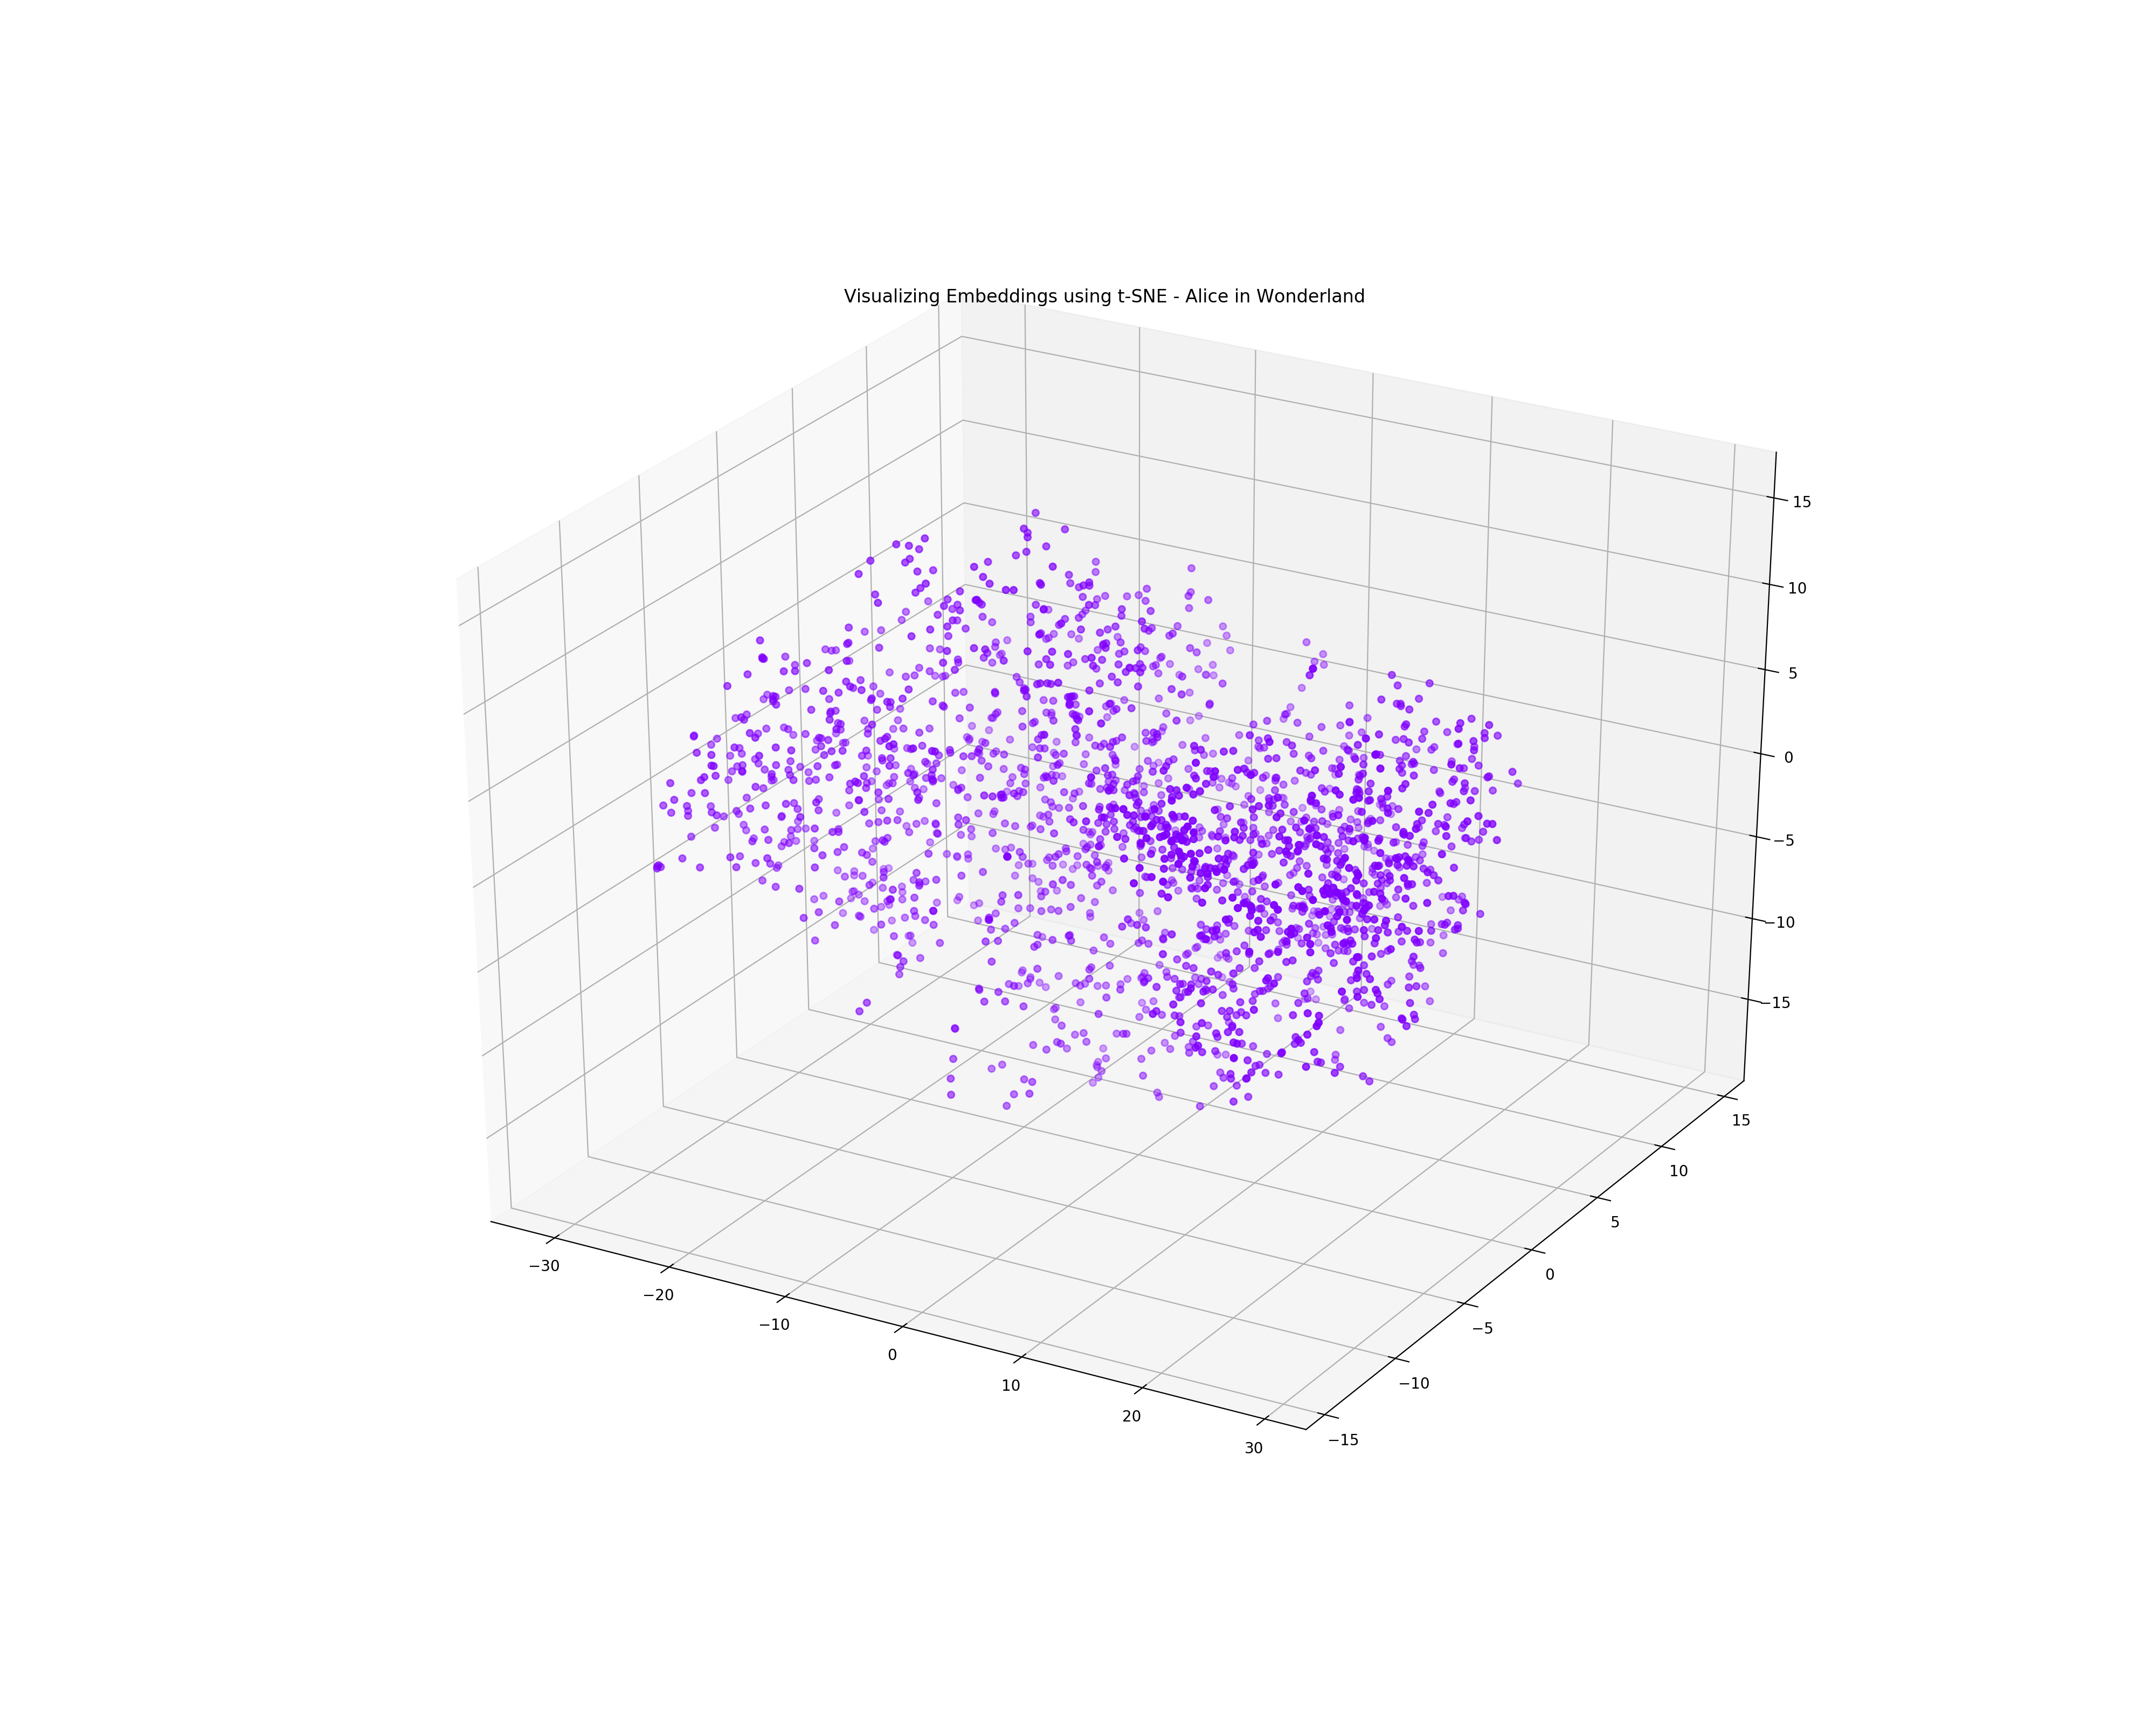

In [27]:
from mpl_toolkits.mplot3d import Axes3D
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
matplotlib.rcParams['figure.figsize'] = (20, 16)
matplotlib.rcParams['figure.dpi'] = 200

def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(xs=embeddings[:, 0], 
                ys=embeddings[:, 1], 
                zs=embeddings[:, 2], 
                c=colors, 
                alpha=a, 
                label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.show()

def tsne_plot_3d2(title, embeddings, a=1): 
    ax = plt.axes(projection='3d')
    colors = cm.rainbow(np.linspace(0, 1, 1))
    ax.scatter3D(embeddings[:, 0], 
                 embeddings[:, 1], 
                 embeddings[:, 2], 
                 c=colors)
    plt.title(title)
    plt.show()

tsne_plot_3d2('Visualizing Embeddings using t-SNE - Alice in Wonderland', embeddings_wp_3d, a=0.1)

### Applications 

Once the model is trained there are many applications. A common forst step os to use k-means clustering to understand any themes or topis that are within the text. Different applications include:

* Sentiment Analysis
* Speech Recognition
* Information Retrieval
* Question Answering

### Out of vacab words and pre-trained models

But what happes if you try and compare similarity between two words when the word2vec model hasnt seen that word before? How can we overcome this?

Pretrained models are available. These are big models and took a huge ammount of effort to train - so there is an advantage that you can download and just start using them. You can immediately inject knowledge from a larger corpus than you might have access to with a smaller dataset: Google's word2vec model has a vocabulary of 3 million words and phrases trained on the google news dataset comprising ~100 billion tokens, and there's no cost to you in training time. 

Compare that to the relatively small book we have used here (~2000 trained words)! However if you have a specilaised corpus (e.g., legal, medical) then it may not capture required knowledge to get meaningful results and you are more likley to get out of vocab results.

### Load Google’s Word2Vec Embedding
Training your own word vectors may be the best approach for a given NLP problem. But it can take a long time, a fast computer with a lot of RAM and disk space, and perhaps some expertise in finessing the input data and training algorithm. An alternative is to simply use an existing pre-trained word embedding.

Along with the paper and code for word2vec, Google also published a pre-trained word2vec model on the Word2Vec Google Code Project.

It is a 1.53 Gigabytes file that you can download from here:
[GoogleNews-vectors-negative300.bin.gz](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)

Unzipped, the binary file (GoogleNews-vectors-negative300.bin) is 3.4 Gigabytes.

The Gensim library provides tools to load this file. Specifically, you can call the KeyedVectors.load_word2vec_format() function to load this model into memory.

```python
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
pretrained_w2v_model = KeyedVectors.load_word2vec_format(filename, binary=True)
```

### Training FastText
You can also train your own text with the FastText model using Gensim. It is very similar to the word2vec example: 


```python
from gensim.models import FastText

# Initialise the model - CBOW 
ft_model = FastText(min_count=1,window=5,size=300)
# Build the vocab
ft_model.build_vocab(sentences_processed, progress_per=10000)
# Train the model
w2v_model.train(data_processed, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

```

A pretrained FastText model is also available and can be loaded into and used by Gensim.

* For .bin use: load_fasttext_format() (this typically contains full model with parameters, ngrams, etc).

* For .vec use: load_word2vec_format (this contains ONLY word-vectors -> no ngrams + you can't update an model).

```python
from gensim.models.wrappers import FastText

pretrained_ft_model = FastText.load_fasttext_format('wiki.simple')

```